In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
sdss = Table.read('fits/sdss_halo_table_matched.fits')
sdss_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

sdss_morph = Table.read('fits/morph_data.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')

masks = Table.read('fits/masks.fits')

In [3]:
in_sdss = masks['z<0.085 (+HI unbarred spiral)']

#### First task: quantify the scatter: how does the scatter vary w.r.t $m_\mathrm{predicted}$?

5666 galaxies in total


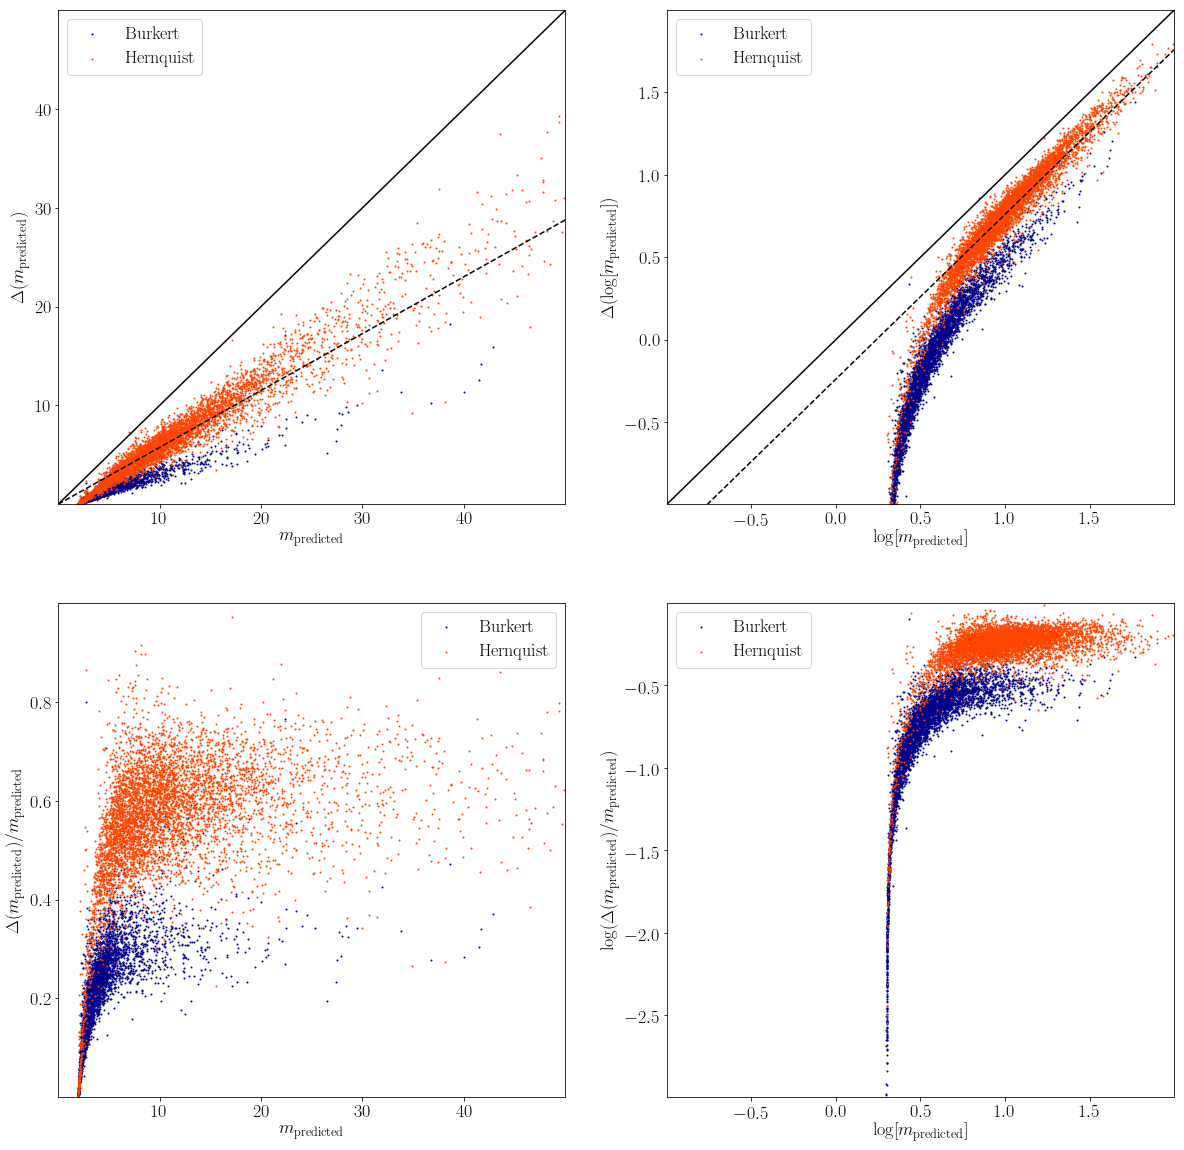

In [4]:
sample = in_sdss
print('{} galaxies in total'.format(sample.sum()))

fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()

m_h = sdss['m_hernquist_2R_d'][sample]
delta_m_h = sdss['delta_m_hernquist_2R_d'][sample]

m_b = sdss['m_burkert_2R_d'][sample]
delta_m_b = sdss['delta_m_burkert_2R_d'][sample]


_ = axarr[0].scatter(m_b,delta_m_b,color='darkblue',s=1,label='Burkert')
_ = axarr[0].scatter(m_h,delta_m_h,color='orangered',s=1,label='Hernquist')

_ = axarr[1].scatter(np.log10(m_b),np.log10(delta_m_b),
                     color='darkblue',s=1,label='Burkert')
_ = axarr[1].scatter(np.log10(m_h),np.log10(delta_m_h),
                     color='orangered',s=1,label='Hernquist')

_ = axarr[2].scatter(m_b,delta_m_b/m_b,
                     color='darkblue',s=1,label='Burkert')
_ = axarr[2].scatter(m_h,delta_m_h/m_h,
                     color='orangered',s=1,label='Hernquist')


_ = axarr[3].scatter(np.log10(m_b),np.log10(delta_m_b/m_b),
                     color='darkblue',s=1,label='Burkert')
_ = axarr[3].scatter(np.log10(m_h),np.log10(delta_m_h/m_h),
                     color='orangered',s=1,label='Hernquist')


xlims = [(0,50),(-1,2),(0,50),(-1,2)]
ylims = [(0,50),(-1,2),(0,1),(-3,0)]
xlabels = ('$m_\mathrm{predicted}$','$\log[m_\mathrm{predicted}]$',
           '$m_\mathrm{predicted}$','$\log[m_\mathrm{predicted}]$')

ylabels = ('$\Delta(m_\mathrm{predicted})$',
           '$\Delta(\log[m_\mathrm{predicted}])$',
           '$\Delta(m_\mathrm{predicted})/m_\mathrm{predicted}$',
           '$\log(\Delta(m_\mathrm{predicted})/m_\mathrm{predicted})$')

for ax, xlim, ylim, xlabel, ylabel in zip(
    axarr,xlims,ylims,xlabels,ylabels):
    
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

_ = axarr[0].plot([-100,100],[-100,100],'k-')
_ = axarr[1].plot([-100,100],[-100,100],'k-')

k = np.median(np.log10(delta_m_h/m_h))

x_guide0 = np.linspace(0,50,100)
y_guide0 = x_guide0 * 10**(k)
_ = axarr[0].plot(x_guide0,y_guide0,'k--')

x_guide1 = np.linspace(-1,2,100)
y_guide1 = k + x_guide1
_ = axarr[1].plot(x_guide1,y_guide1,'k--')

In [5]:
#### fit some kind of line to make sampling consistent?
'''
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

x = np.log10(m_h)
y = np.log10(delta_m_h)

_ = plt.scatter(x,y,color='r',s=1)
for offset in [-1,-0.5,0,0.5,1]:
    _ = plt.plot([-10,10],[-10+offset,10+offset],'k--')

def func(x,k,c,a):
    return k * np.exp(-x) + c

_ = plt.xlim(0,2.5)
_ = plt.ylim(-0.5,2)
_ = plt.xlabel('$\log[m_\mathrm{predicted}]$')
_ = plt.ylabel('$\Delta(\log[m_\mathrm{predicted}])$')

p, _ = curve_fit(func,x,y)
x_guide = np.linspace(0.4,3,1000)
y_guide = func(x_guide,*p)
_ = plt.plot(x_guide,y_guide,'b-',label='function fit')

svr = GridSearchCV(SVR(kernel='rbf',C=1e3),{'gamma':np.logspace(-2,0,5)})
svr.fit(x[:,np.newaxis],y[:,np.newaxis])
y_guide_r = svr.predict(x_guide[:,np.newaxis])
_ = plt.plot(x_guide,y_guide_r,color='g',lw=2)

'''

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.svm import SVR\n\nx = np.log10(m_h)\ny = np.log10(delta_m_h)\n\n_ = plt.scatter(x,y,color='r',s=1)\nfor offset in [-1,-0.5,0,0.5,1]:\n    _ = plt.plot([-10,10],[-10+offset,10+offset],'k--')\n\ndef func(x,k,c,a):\n    return k * np.exp(-x) + c\n\n_ = plt.xlim(0,2.5)\n_ = plt.ylim(-0.5,2)\n_ = plt.xlabel('$\\log[m_\\mathrm{predicted}]$')\n_ = plt.ylabel('$\\Delta(\\log[m_\\mathrm{predicted}])$')\n\np, _ = curve_fit(func,x,y)\nx_guide = np.linspace(0.4,3,1000)\ny_guide = func(x_guide,*p)\n_ = plt.plot(x_guide,y_guide,'b-',label='function fit')\n\nsvr = GridSearchCV(SVR(kernel='rbf',C=1e3),{'gamma':np.logspace(-2,0,5)})\nsvr.fit(x[:,np.newaxis],y[:,np.newaxis])\ny_guide_r = svr.predict(x_guide[:,np.newaxis])\n_ = plt.plot(x_guide,y_guide_r,color='g',lw=2)\n\n"

In [6]:
'''
predicted_delta_m_h = 10**(svr.predict(x[:,np.newaxis]))

_ = plt.hist(delta_m_h/predicted_delta_m_h,bins=np.linspace(0,2,101),
             color='k',alpha=0.2)
'''

"\npredicted_delta_m_h = 10**(svr.predict(x[:,np.newaxis]))\n\n_ = plt.hist(delta_m_h/predicted_delta_m_h,bins=np.linspace(0,2,101),\n             color='k',alpha=0.2)\n"

r_s(m,m)=0.41990366919931466


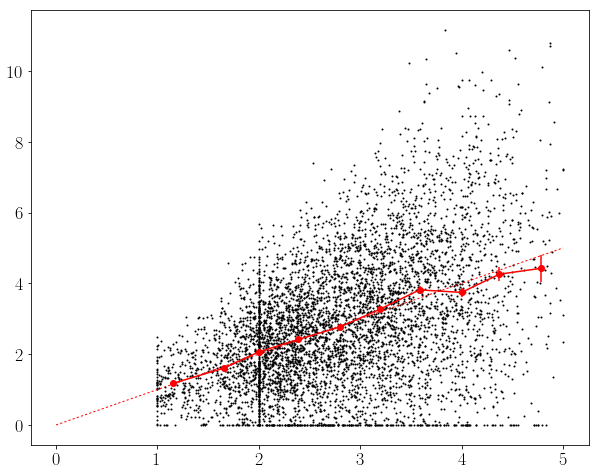

In [7]:
# set up some 'mock' observations
from scipy.stats import spearmanr
from xy_plots import x_vs_y

fig = plt.figure()
ax = plt.subplot(111)

#intrinsic_scatter = 5*np.random.randn(len(m_true))
intrinsic_scatter = 0

m_true = sdss_morph['m_avg'][sample]
scatter = np.random.randn(len(m_true))
error_factor = m_true * 10**k

m_model = m_true + scatter * error_factor + intrinsic_scatter
m_model[m_model < 0] = 0
xy = x_vs_y(m_true,m_model).continuous_vs_continuous_binned_median()
xy.error_plot(ax,style='errorbar',color='r',marker='o')

_ = ax.scatter(m_true,m_model,s=1,color='k')
_ = ax.plot([0,5],[0,5],color='r',lw=1,linestyle='dotted')

r_s, _ = spearmanr(m_true,m_model)
print('r_s(m,m)={}'.format(r_s))

#### Now set up some mock observations in terms of m_b and m_d

In [8]:
def mock_observation(m_true,f=1,intrinsic_scatter=0.5):
    
    N_gal = len(m_true)
    m_model = m_true.copy()
    scatter = m_true * intrinsic_scatter * np.random.randn(N_gal)
    m_model += scatter
    
    N_unmodel = int(np.round((1-f)*N_gal,decimals=0))
    if N_unmodel >= 1:
        m_unmodel = np.random.choice(m_true,N_unmodel)
        i_unmodel = np.random.choice(range(N_gal),N_unmodel,replace=False)
        m_model[i_unmodel] = m_unmodel
    m_model[m_model <= 0] = 0
    return m_true, m_model

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


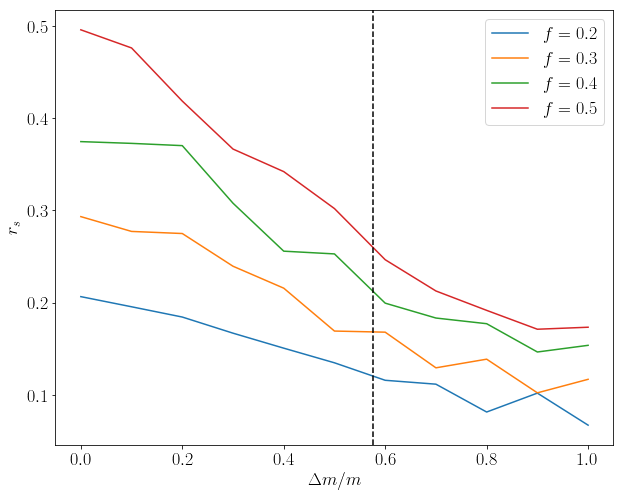

In [9]:
fig = plt.figure()
ax = plt.subplot(111)

true_fractions = [0.2,0.3,0.4,0.5]
intrinsic_scatters = np.linspace(0,1,11)

for f in true_fractions:
    r_s = []
    for i in intrinsic_scatters:
        x,y = mock_observation(m_true,f,i)
        r_s.append(spearmanr(x,y)[0])
    ax.plot(intrinsic_scatters,r_s,label='$f={}$'.format(f))
    
plt.sca(ax)
_ = plt.axvline(10**k,color='k',linestyle='dashed')

_ = ax.set_xlabel('$\Delta m/m$')
_ = ax.set_ylabel('$r_s$')
_ = ax.legend()

#### Correlating errors: how does $\Delta m/m$ compare with:

* $\Delta M_B / M_D$
* $\Delta M_D / M_D$
* $\Delta R_D/ R_D$
* $\Delta R_B/ R_D$

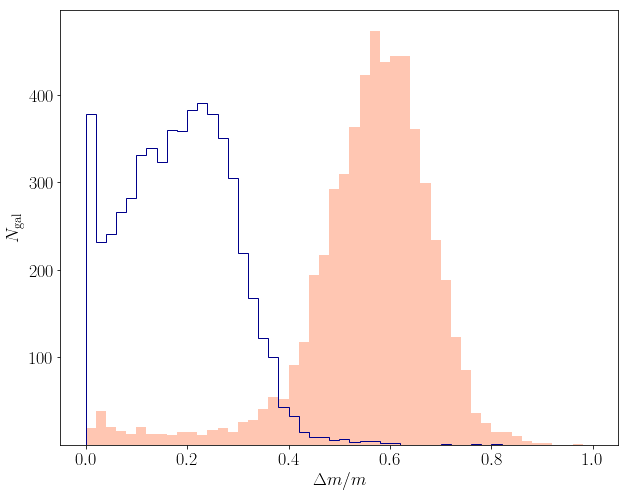

In [10]:
bins = np.linspace(0,1,51)
_ = plt.hist(delta_m_h/m_h,bins=bins,color='orangered',alpha=0.3,
             label='Hernquist')
_ = plt.hist(delta_m_b/m_b,bins=bins,histtype='step',color='darkblue',
             label='Burkert')

_ = plt.xlabel('$\Delta m / m$')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [11]:
def m_error_plotter(ax,x,xlabel=''):
    _ = ax.scatter(x,delta_m_h/m_h,color='orangered',s=1)
    _ = ax.scatter(x,delta_m_b/m_b,color='darkblue',s=1)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel('$\Delta m / m$')
    _ = ax.set_xlim(0,1)
    _ = ax.set_ylim(0,1)
    return None

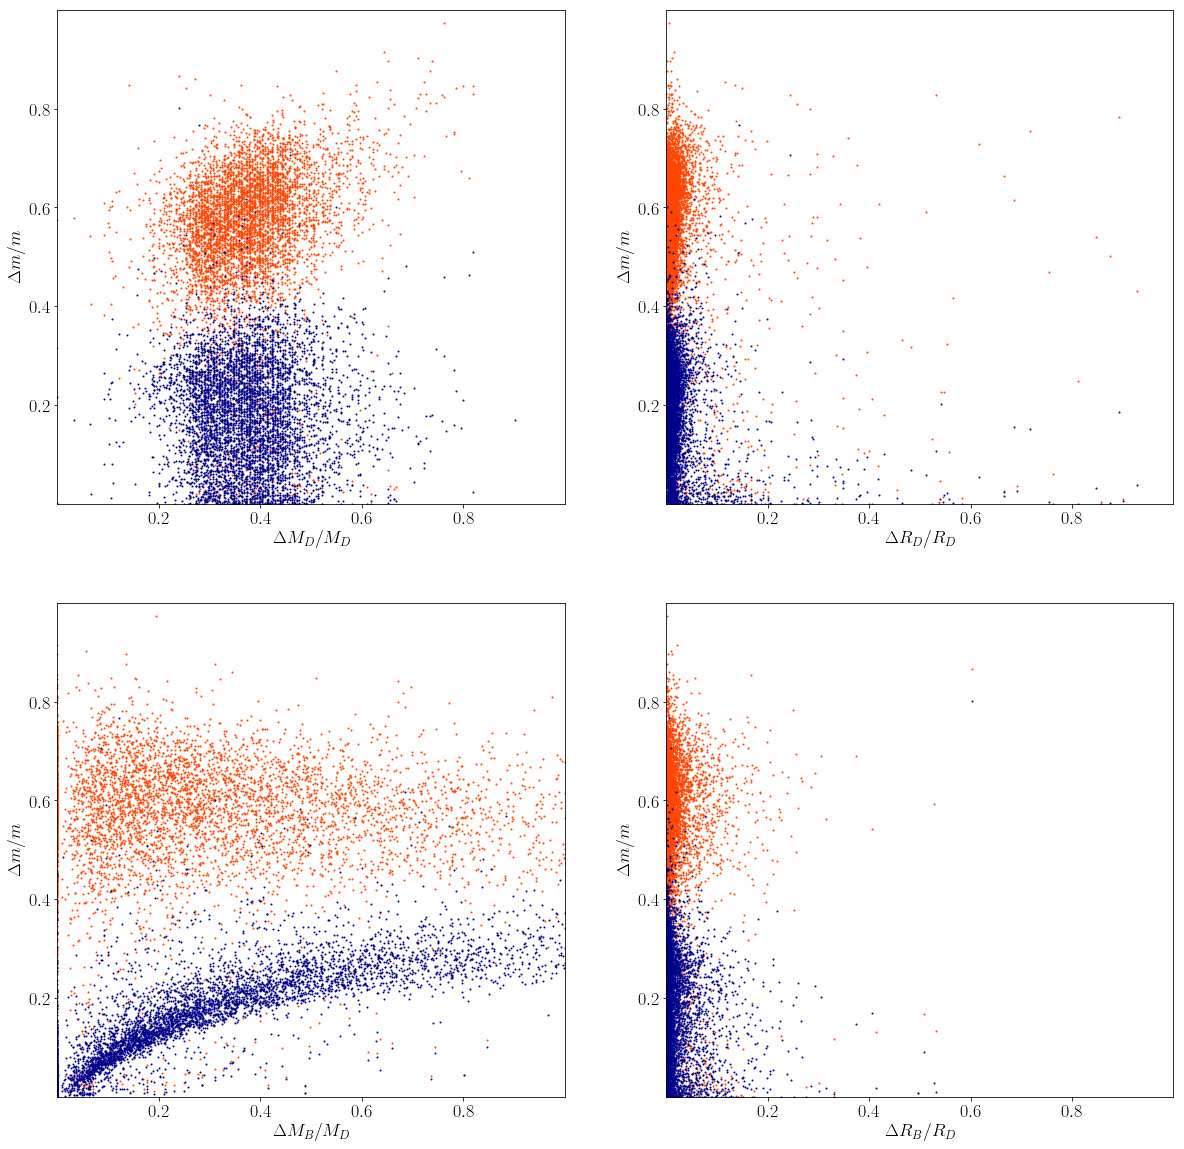

In [12]:
colnames = ['M_disc_total','delta_M_disc_total',
            'R_disc_total','delta_R_disc_total',
            'M_bulge','delta_M_bulge',
            'R_bulge','delta_R_bulge']

(M_d, delta_M_d, R_d, delta_R_d, 
 M_b, delta_M_b, R_b, delta_R_b) = [sdss[c][sample] for c in colnames]

fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()

xs = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]
xlabels = ['$\Delta M_D/M_D$','$\Delta R_D/ R_D$',
           '$\Delta M_B/ M_D$', '$\Delta R_B/ R_D$']

for ax, x, xlabel in zip(axarr,xs,xlabels):
    _ = m_error_plotter(ax,x,xlabel)

#### Final task: make $m_\mathrm{predicted}$ vs $m$ for various cuts

Here, we will purely focus on the Hernquist profile, as this leads to a clear correlation. We will use the stellar profile for now, as the inclusion of gas makes little difference to the emergence of a correlation.

Best p = 1.0
N_gal = 5099


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


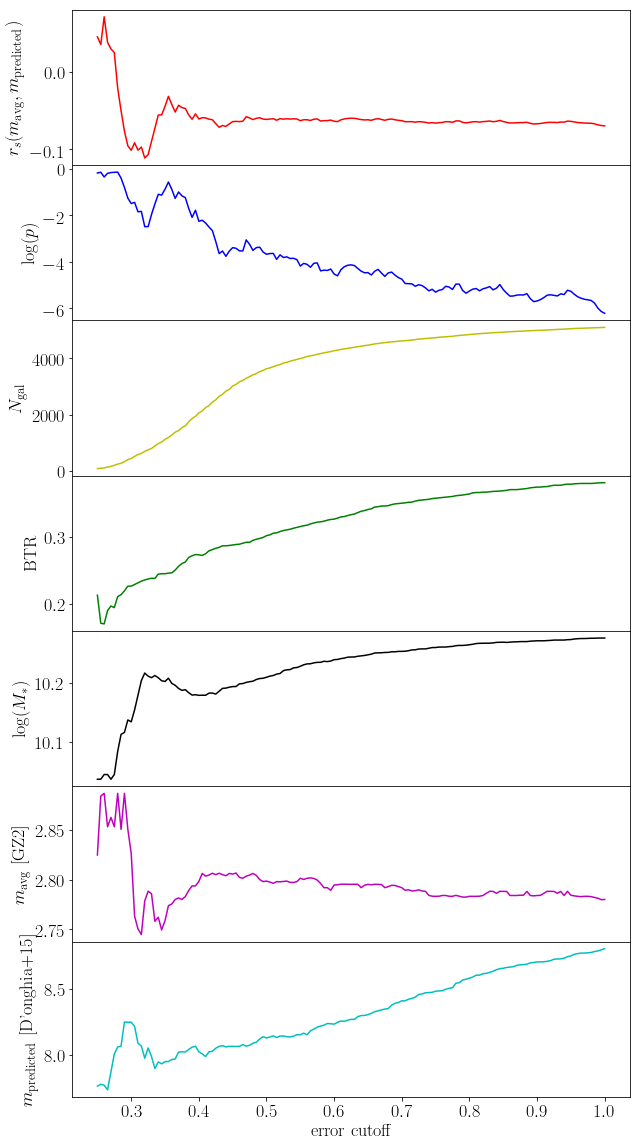

In [13]:
error_limits = np.linspace(0.25,1,151)

x = sdss_morph['m_avg'][sample]
y = m_h
#delta_ys = [delta_m_h / m_h, delta_m_b/m_b]
delta_ys = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]

m_tot = np.log10(sdss['M_disc_stars'] + sdss['M_bulge'])[sample]
b_to_t = sdss['M_bulge'][sample] / 10**m_tot

r_s = []
N_gal = []
btr = []
logmstar = []
p_values = []
m_values = []
m_predicted_values = []

for elim in error_limits:
    error_ok = np.all([delta_y <= elim for delta_y in delta_ys],axis=0)
    x_ = x[error_ok]
    y_ = y[error_ok]
    r_s.append(spearmanr(x_,y_)[0])
    p_values.append(np.log10(spearmanr(x_,y_)[1]))
    N_gal.append(error_ok.sum())#/len(error_ok))
    btr.append(np.median(b_to_t[error_ok]))
    logmstar.append(np.median(m_tot[error_ok]))
    m_values.append(np.median(x[error_ok]))
    m_predicted_values.append(np.median(y[error_ok]))
    
fig, axarr = plt.subplots(7,1,figsize=(10,20),sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

ys = [r_s,p_values,N_gal,btr,logmstar,m_values,m_predicted_values]
ylabels = ('$r_s(m_\mathrm{avg},m_\mathrm{predicted})$',
           '$\log(p)$',
           '$N_\mathrm{gal}$','BTR','$\log(M_*)$','$m_\mathrm{avg}$ [GZ2]',
           "$m_\mathrm{predicted}$ [D'onghia+15]")

colors = 'rbygkmc'

for ax, y_, ylabel,color in zip(axarr,ys,ylabels,colors):
    
    _ = ax.plot(error_limits,y_,color=color)
    _ = ax.set_ylabel(ylabel)

_ = axarr[-1].set_xlabel('error cutoff')

print('Best p = {}'.format(error_limits[np.argmin(p_values)]))
print('N_gal = {}'.format(N_gal[np.argmin(p_values)]))

Best p = 0.865
N_gal = 5657


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


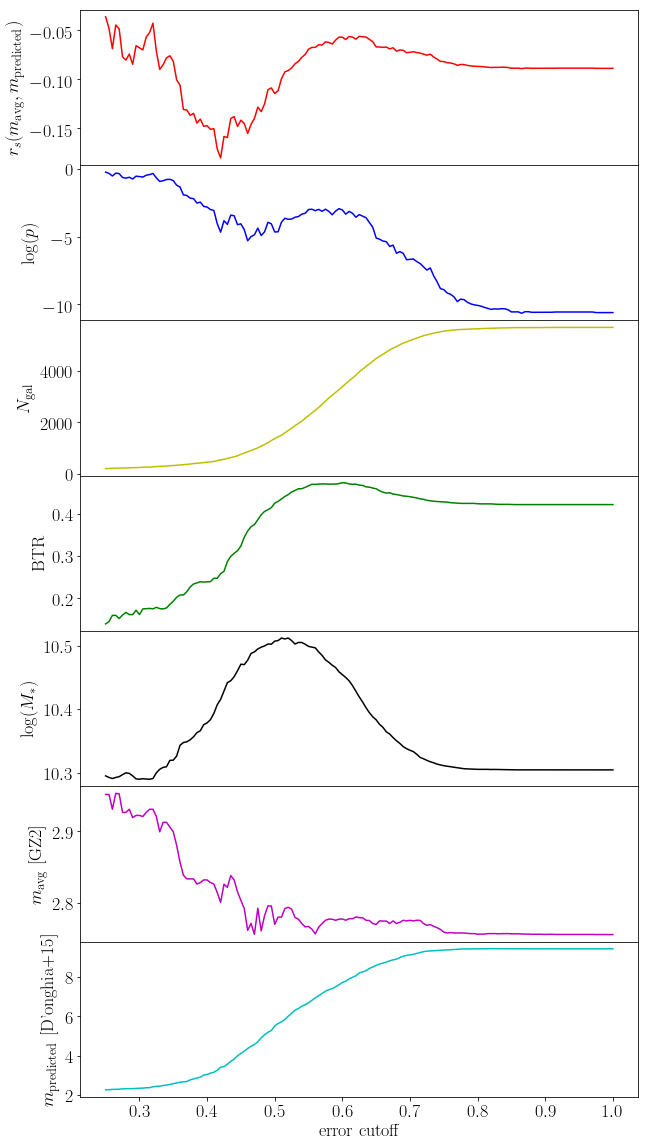

In [14]:
error_limits = np.linspace(0.25,1,151)

x = sdss_morph['m_avg'][sample]
y = m_h
delta_ys = [delta_m_h / m_h, delta_m_b/m_b]
#delta_ys = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]

m_tot = np.log10(sdss['M_disc_stars'] + sdss['M_bulge'])[sample]
b_to_t = sdss['M_bulge'][sample] / 10**m_tot

r_s = []
N_gal = []
btr = []
logmstar = []
p_values = []
m_values = []
m_predicted_values = []

for elim in error_limits:
    error_ok = np.all([delta_y <= elim for delta_y in delta_ys],axis=0)
    x_ = x[error_ok]
    y_ = y[error_ok]
    r_s.append(spearmanr(x_,y_)[0])
    p_values.append(np.log10(spearmanr(x_,y_)[1]))
    N_gal.append(error_ok.sum())#/len(error_ok))
    btr.append(np.median(b_to_t[error_ok]))
    logmstar.append(np.median(m_tot[error_ok]))
    m_values.append(np.median(x[error_ok]))
    m_predicted_values.append(np.median(y[error_ok]))
    
fig, axarr = plt.subplots(7,1,figsize=(10,20),sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

ys = [r_s,p_values,N_gal,btr,logmstar,m_values,m_predicted_values]
ylabels = ('$r_s(m_\mathrm{avg},m_\mathrm{predicted})$',
           '$\log(p)$',
           '$N_\mathrm{gal}$','BTR','$\log(M_*)$','$m_\mathrm{avg}$ [GZ2]',
           "$m_\mathrm{predicted}$ [D'onghia+15]")

colors = 'rbygkmc'

for ax, y_, ylabel,color in zip(axarr,ys,ylabels,colors):
    
    _ = ax.plot(error_limits,y_,color=color)
    _ = ax.set_ylabel(ylabel)

_ = axarr[-1].set_xlabel('error cutoff')

print('Best p = {}'.format(error_limits[np.argmin(p_values)]))
print('N_gal = {}'.format(N_gal[np.argmin(p_values)]))

In [15]:
'''
error_limits = np.linspace(0.75,2,101)

x = sdss_morph['m_avg'][sample]
y = m_h
delta_ys = [delta_m_h / predicted_delta_m_h]
#delta_ys = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]

m_tot = np.log10(sdss['M_disc_stars'] + sdss['M_bulge'])[sample]
b_to_t = sdss['M_bulge'][sample] / 10**m_tot

r_s = []
N_gal = []
btr = []
logmstar = []
p_values = []
m_values = []
m_predicted_values = []

for elim in error_limits:
    error_ok = np.all([delta_y <= elim for delta_y in delta_ys],axis=0)
    x_ = x[error_ok]
    y_ = y[error_ok]
    r_s.append(spearmanr(x_,y_)[0])
    p_values.append(np.log10(spearmanr(x_,y_)[1]))
    N_gal.append(error_ok.sum())#/len(error_ok))
    btr.append(np.median(b_to_t[error_ok]))
    logmstar.append(np.median(m_tot[error_ok]))
    m_values.append(np.median(x[error_ok]))
    m_predicted_values.append(np.median(y[error_ok]))
    
fig, axarr = plt.subplots(7,1,figsize=(10,20),sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

ys = [r_s,p_values,N_gal,btr,logmstar,m_values,m_predicted_values]
ylabels = ('$r_s(m_\mathrm{avg},m_\mathrm{predicted})$',
           '$\log(p)$',
           '$N_\mathrm{gal}$','BTR','$\log(M_*)$','$m_\mathrm{avg}$ [GZ2]',
           "$m_\mathrm{predicted}$ [D'onghia+15]")

colors = 'rbygkmc'

for ax, y_, ylabel,color in zip(axarr,ys,ylabels,colors):
    
    _ = ax.plot(error_limits,y_,color=color)
    _ = ax.set_ylabel(ylabel)

_ = axarr[-1].set_xlabel('error cutoff')

print('Best p = {}'.format(error_limits[np.argmin(p_values)]))
print('N_gal = {}'.format(N_gal[np.argmin(p_values)]))
'''

'\nerror_limits = np.linspace(0.75,2,101)\n\nx = sdss_morph[\'m_avg\'][sample]\ny = m_h\ndelta_ys = [delta_m_h / predicted_delta_m_h]\n#delta_ys = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]\n\nm_tot = np.log10(sdss[\'M_disc_stars\'] + sdss[\'M_bulge\'])[sample]\nb_to_t = sdss[\'M_bulge\'][sample] / 10**m_tot\n\nr_s = []\nN_gal = []\nbtr = []\nlogmstar = []\np_values = []\nm_values = []\nm_predicted_values = []\n\nfor elim in error_limits:\n    error_ok = np.all([delta_y <= elim for delta_y in delta_ys],axis=0)\n    x_ = x[error_ok]\n    y_ = y[error_ok]\n    r_s.append(spearmanr(x_,y_)[0])\n    p_values.append(np.log10(spearmanr(x_,y_)[1]))\n    N_gal.append(error_ok.sum())#/len(error_ok))\n    btr.append(np.median(b_to_t[error_ok]))\n    logmstar.append(np.median(m_tot[error_ok]))\n    m_values.append(np.median(x[error_ok]))\n    m_predicted_values.append(np.median(y[error_ok]))\n    \nfig, axarr = plt.subplots(7,1,figsize=(10,20),sharex=True)\nfig.subplots_adjust(ws

#### How about: correlation vs. btr for _all_ galaxies?

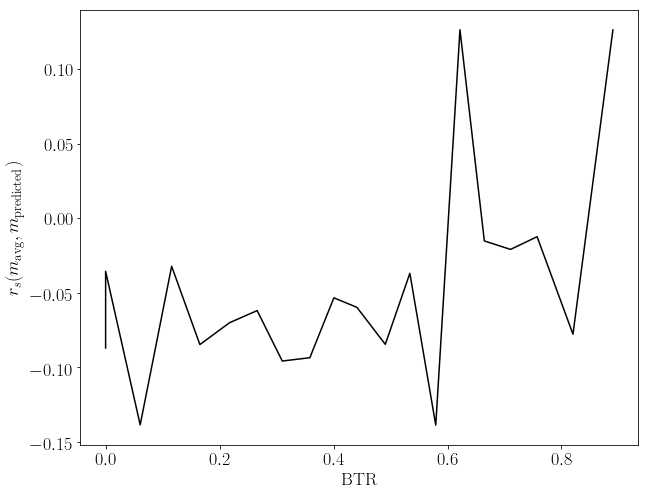

In [16]:
from bin_statistics import assign_bins

delta_y = delta_m_h / m_h

xbins = assign_bins(b_to_t,equal_N=True,N_bins=20)
btr_list = []
r_s_list = []
for b in np.unique(xbins):
    in_bin = xbins == b
    btr_list.append(np.median(b_to_t[in_bin]))
    x_ = x[in_bin]
    y_=  y[in_bin]
    r_s_list.append(spearmanr(x_,y_)[0])
    
_ = plt.plot(btr_list,r_s_list,'k-')
_ = plt.xlabel('BTR')
_ = plt.ylabel('$r_s(m_\mathrm{avg},m_\mathrm{predicted})$')

If _anything_, the model agrees better in the case where the bulge-to-total mass is greater. This would suggest that all of the differences are induced by the errors becoming _too large_. 

#### Finally: what does the sample selection/incompleteness look like?

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


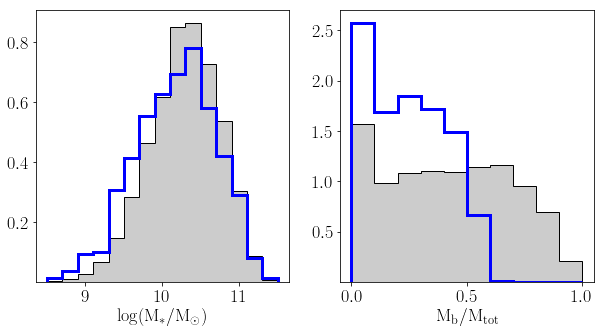

In [17]:
delta_ys = [delta_M_d/M_d, delta_R_d/R_d, delta_M_b/M_d, delta_R_b/R_d]

full_sample = sample.copy()
reduced_sample = np.full(len(full_sample),False)
reduced_sample[full_sample] = np.all([delta_y <= 1/3 for delta_y in delta_ys],
                                     axis=0)

totalmass = np.log10(sdss['M_disc_stars']+sdss['M_bulge'])
btr = sdss['M_bulge'] / 10**(totalmass)

fig, axarr = plt.subplots(1,2,figsize=(10,5))

mass_bins = np.linspace(8.5,11.5,16)
btr_bins = np.linspace(0,1,11)

m0 = axarr[0].hist(totalmass[full_sample],mass_bins,normed=True,
                  histtype='stepfilled',color='k',alpha=0.2)
_ = axarr[0].hist(totalmass[full_sample],mass_bins,normed=True,
                  histtype='step',color='k',lw=1)
b0 = axarr[1].hist(btr[full_sample],btr_bins,normed=True,
                  histtype='stepfilled',color='k',alpha=0.2)
_ = axarr[1].hist(btr[full_sample],btr_bins,normed=True,
                  histtype='step',color='k',lw=1)

m1 = axarr[0].hist(totalmass[reduced_sample],mass_bins,normed=True,
                  histtype='step',color='b',lw=3)
b1 = axarr[1].hist(btr[reduced_sample],btr_bins,normed=True,
                  histtype='step',color='b',lw=3)

_ = axarr[0].set_xlabel('$\log(\mathrm{M_*/M_\odot})$')
_ = axarr[1].set_xlabel('$\mathrm{M_b/M_{tot}}$')

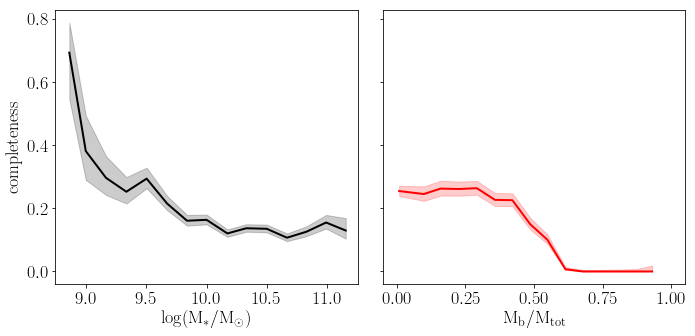

In [18]:
fig, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)

xy = x_vs_y(totalmass[full_sample],reduced_sample[full_sample],
            x_range=(8.75,11.25))
xy = xy.fraction_with_feature(bins=15)
xy.line_plot(axarr[0],color='k',lw=2)
xy.error_plot(axarr[0],style='filled',color='k',alpha=0.2)
_ = axarr[0].set_xlabel('$\log(\mathrm{M_*/M_\odot})$')
_ = axarr[0].set_ylabel('completeness')
_ = axarr[0].set_xticks([9,9.5,10,10.5,11])
_ = axarr[0].set_xlim(8.75,11.25)

xy = x_vs_y(btr[full_sample],reduced_sample[full_sample])
xy = xy.fraction_with_feature(bins=15)
xy.line_plot(axarr[1],color='r',lw=2)
xy.error_plot(axarr[1],style='filled',color='r',alpha=0.2)
_ = axarr[1].set_xlabel('$\mathrm{M_b/M_{tot}}$')
_ = axarr[1].set_xticks([0,0.25,0.5,0.75,1])
_ = axarr[1].set_xlim(-0.05,1.05)

fig.tight_layout()
#fig.subplots_adjust(wspace=0,hspace=0)